In [1]:
import GPflow
import numpy as np
import matplotlib.pyplot as plt
#plt.style.use('ggplot')
%matplotlib inline

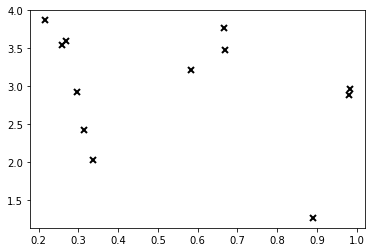

In [2]:
N = 12
X = np.random.rand(N,1)
Y = np.sin(12*X) + 0.66*np.cos(25*X) + np.random.randn(N,1)*0.1 + 3
plt.plot(X, Y, 'kx', mew=2)

In [3]:
X, Y

(array([[ 0.667873  ],
        [ 0.98285313],
        [ 0.66608872],
        [ 0.33602451],
        [ 0.31291733],
        [ 0.25918499],
        [ 0.89117665],
        [ 0.2680176 ],
        [ 0.58268115],
        [ 0.98193001],
        [ 0.2969178 ],
        [ 0.21696126]]), array([[ 3.48194118],
        [ 2.96156223],
        [ 3.76988571],
        [ 2.02138215],
        [ 2.42337718],
        [ 3.54800489],
        [ 1.26054547],
        [ 3.59877687],
        [ 3.21915604],
        [ 2.88919411],
        [ 2.92525211],
        [ 3.87038579]]))

In [4]:
k = GPflow.kernels.Matern52(1, lengthscales=0.3)
m = GPflow.gpr.GPR(X, Y, kern=k)
m.likelihood.variance = 0.01

In [5]:
m.kern

Name,values,prior,constraint
kern.lengthscales,[ 0.3],None,+ve
kern.variance,[ 1.],None,+ve


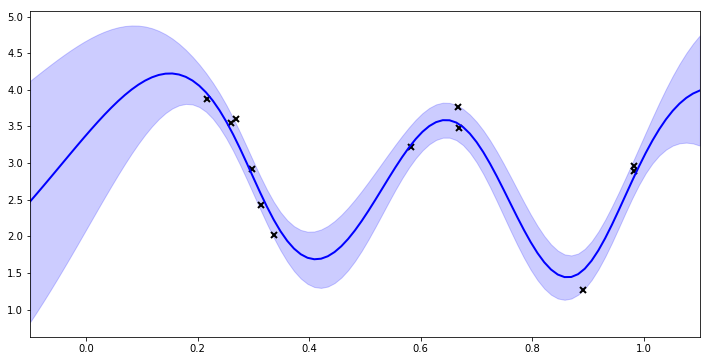

In [6]:
def plot(m):
    # [:, None] is a cute trick to turn a 1d array into a 2d array (instead of np.atleast2d())
    xx = np.linspace(-0.1, 1.1, 100)[:,None]
    mean, var = m.predict_y(xx)
    plt.figure(figsize=(12, 6))
    plt.plot(X, Y, 'kx', mew=2)
    plt.plot(xx, mean, 'b', lw=2)
    plt.fill_between(xx[:,0], mean[:,0] - 2*np.sqrt(var[:,0]), mean[:,0] + 2*np.sqrt(var[:,0]), color='blue', alpha=0.2)
    plt.xlim(-0.1, 1.1)
plot(m)

In [7]:
k = GPflow.kernels.Matern52(1, lengthscales=0.3)
meanf = GPflow.mean_functions.Linear(1,0)
m = GPflow.gpr.GPR(X, Y, k, meanf)
m.likelihood.variance = 0.01

m

Name,values,prior,constraint
model.mean_function.b,[ 0.],None,(none)
model.mean_function.A,[[ 1.]],None,(none)
model.likelihood.variance,[ 0.01],None,+ve
model.kern.lengthscales,[ 0.3],None,+ve
model.kern.variance,[ 1.],None,+ve


Name,values,prior,constraint
model.mean_function.b,[ 3.55539376],None,(none)
model.mean_function.A,[[-1.20569526]],None,(none)
model.likelihood.variance,[ 0.01400372],None,+ve
model.kern.lengthscales,[ 0.06383187],None,+ve
model.kern.variance,[ 0.68009618],None,+ve


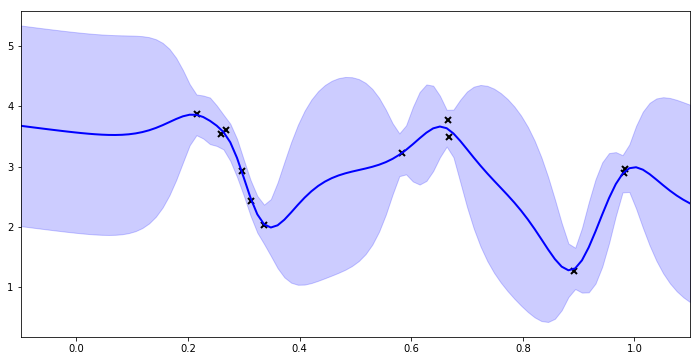

In [8]:
m.optimize()
plot(m)
m

In [9]:
m.kern.lengthscales.prior = GPflow.priors.Gamma(1., 1.)
m.kern.variance.prior = GPflow.priors.Gamma(1., 1.)
m.likelihood.variance.prior = GPflow.priors.Gamma(1., 1.)
m.mean_function.A.prior = GPflow.priors.Gaussian(0., 10.)
m.mean_function.b.prior = GPflow.priors.Gaussian(0., 10.)
m

Name,values,prior,constraint
model.mean_function.b,[ 3.55539376],"N([ 0.],[ 10.])",(none)
model.mean_function.A,[[-1.20569526]],"N([ 0.],[ 10.])",(none)
model.likelihood.variance,[ 0.01400372],"Ga([ 1.],[ 1.])",+ve
model.kern.lengthscales,[ 0.06383187],"Ga([ 1.],[ 1.])",+ve
model.kern.variance,[ 0.68009618],"Ga([ 1.],[ 1.])",+ve


In [10]:
samples = m.sample(500, epsilon=0.2, verbose=1)

Iteration:  100 	 Acc Rate:  94.0 %
Iteration:  200 	 Acc Rate:  96.0 %
Iteration:  300 	 Acc Rate:  100.0 %
Iteration:  400 	 Acc Rate:  92.0 %
Iteration:  500 	 Acc Rate:  98.0 %


In [11]:
sample_df = m.get_samples_df(samples)
sample_df.head()

,model.mean_function.b,model.mean_function.A,model.likelihood.variance,model.kern.lengthscales,model.kern.variance
0,[3.55539375921],[[-1.20569525941]],[0.0140037180843],[0.0638318726101],[0.68009618456]
1,[3.89147343957],[[-1.44010206915]],[0.095735946354],[0.115804348027],[3.64701365744]
2,[2.23543341359],[[0.436774459105]],[0.0204880098254],[0.0341770230403],[0.696042081902]
3,[2.78903590341],[[0.611300427405]],[0.022744381587],[0.102526653834],[0.904691663258]
4,[2.63600098533],[[0.993717817761]],[0.0212075038938],[0.153694039975],[2.34741282448]


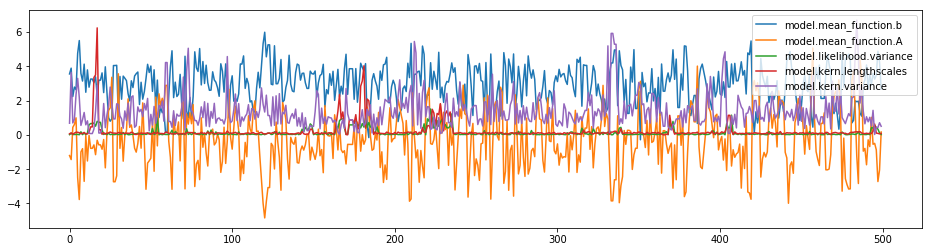

In [12]:
# make a more informative plot
plt.figure(figsize=(16, 4))
for lab, s in sample_df.iteritems():
    plt.plot(s, label=lab)

plt.legend(loc=1)

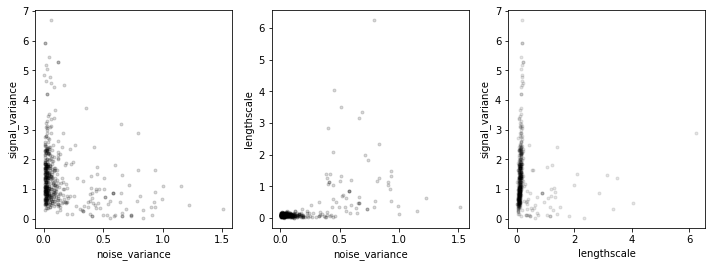

In [13]:
f, axs = plt.subplots(1,3, figsize=(12,4))

axs[0].plot(sample_df['model.likelihood.variance'],
            sample_df['model.kern.variance'], 'k.', alpha = 0.15)
axs[0].set_xlabel('noise_variance')
axs[0].set_ylabel('signal_variance')

axs[1].plot(sample_df['model.likelihood.variance'],
            sample_df['model.kern.lengthscales'], 'k.', alpha = 0.15)
axs[1].set_xlabel('noise_variance')
axs[1].set_ylabel('lengthscale')

axs[2].plot(sample_df['model.kern.lengthscales'],
            sample_df['model.kern.variance'], 'k.', alpha = 0.1)
axs[2].set_xlabel('lengthscale')
axs[2].set_ylabel('signal_variance')

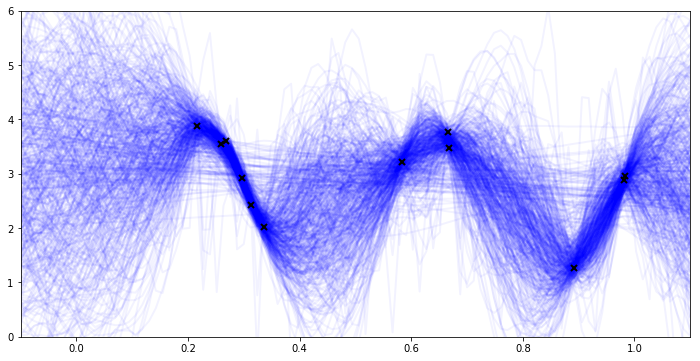

In [14]:
#plot the function posterior
xx = np.linspace(-0.1, 1.1, 100)[:,None]
plt.figure(figsize=(12, 6))
for i, s in sample_df.iterrows():
    m.set_parameter_dict(s)
    f = m.predict_f_samples(xx, 1)
    plt.plot(xx, f[0,:,:], 'b', lw=2, alpha = 0.05)

plt.plot(X, Y, 'kx', mew=2)
_ = plt.xlim(xx.min(), xx.max())
_ = plt.ylim(0, 6)